In [ ]:
#Mount personal Google Drive to colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/UU/AI_for_IA/Autoencoders')

Mounted at /content/drive


In [ ]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

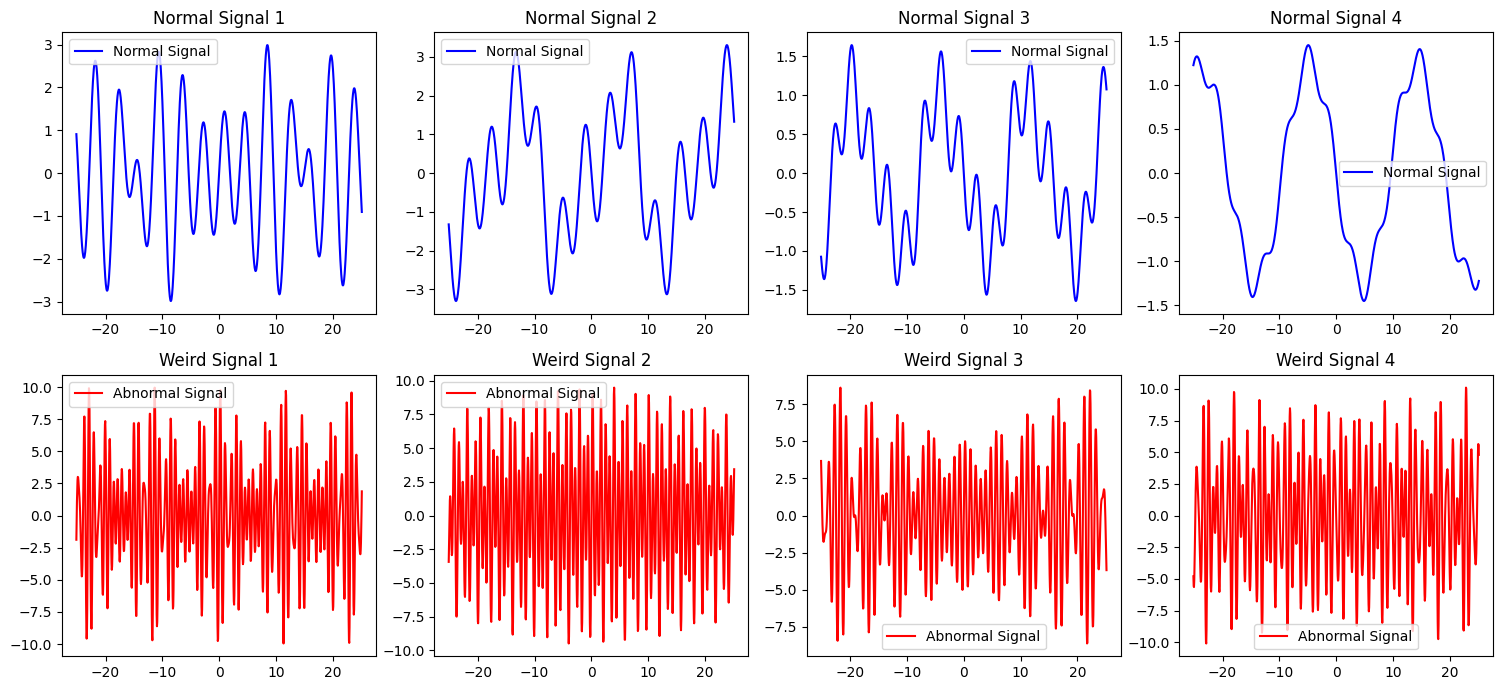

In [ ]:
#Define x range
x_range = np.linspace(-8 * np.pi, 8 * np.pi, 1000)

normal_frequencies = np.linspace(-2, 2, 1000)
weird_frequencies = np.hstack((np.linspace(-10, -5, 500), np.linspace(5, 10, 500)))

normal_amplitudes = np.linspace(-2, 2, 1000)
weird_amplitudes = np.hstack((np.linspace(-5, -2, 500), np.linspace(2, 5, 500)))


def build_signals(frequencies ,amplitudes ,num=1000, num_components=3):
  signals = []
  for _ in range(num):
    freqs = np.random.choice(frequencies, num_components)
    amps = np.random.choice(amplitudes, num_components)
    sigs = [amps[i] * np.sin(freqs[i] * x_range) for i in range(num_components)]
    signals.append(np.sum(sigs, axis=0))
  return np.array(signals)


normal_signals = build_signals(normal_frequencies, normal_amplitudes, num=1000, num_components=3)
weird_signals = build_signals(weird_frequencies, weird_amplitudes, num=1000, num_components=3)

#Plot normal and weird signals
plt.figure(figsize=(15, 7))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    if i > 4:  #Plot weird signals
        plt.plot(x_range, weird_signals[np.random.choice(500)], label='Abnormal Signal', color='r')
        plt.title(f'Weird Signal {i-4}')
    else:  #Plot normal signals
        plt.plot(x_range, normal_signals[np.random.choice(500)], label='Normal Signal', color='b')
        plt.title(f'Normal Signal {i}')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Define Autoencoder model

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  # (B, 32, L)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),  # Downsample (B, 32, L/2)
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),  # (B, 16, L/2)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0)   # Downsample (B, 16, L/4)
        )

        #Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),  # (B, 16, L/4)
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # Upsample (B, 16, L/2)
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),  # (B, 32, L/2)
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # Upsample (B, 32, L)
            nn.Conv1d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),  # (B, 1, L)
            nn.Identity()  # Final layer; linear activation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
#Define dataloeaders
num_signals = 1000
batch_size = 32
sequence_length = len(normal_signals)
normal_signals = normal_signals.reshape( num_signals, 1,  sequence_length)  # Shape: (batch_size, 1, sequence_length)
print("Normal Signals Shape:", normal_signals.shape)

#Train data
train_data = torch.tensor(normal_signals, dtype=torch.float32)
train_dataset = TensorDataset(train_data, train_data)

#Split validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)

print(f"Number of signals: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")

Normal Signals Shape: (1000, 1, 1000)
Number of signals: 800
Number of batches: 25


In [ ]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the model, loss function, and optimizer
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
train_batch_losses = []
valid_losses = []
valid_batch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for signals, _ in train_loader:
        signals = signals.to(device)  # Move data to the device

        #Forward pass
        outputs = model(signals)
        loss = criterion(outputs, signals)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_batch_losses.append(loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for val_signals, _ in valid_loader:
            val_signals = val_signals.to(device)  # Move data to the device
            val_outputs = model(val_signals)
            batch_val_loss = criterion(val_outputs, val_signals).item()
            val_loss += batch_val_loss
            valid_batch_losses.append(batch_val_loss)
        avg_val_loss = val_loss / len(valid_loader)
        valid_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")


"""plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(valid_losses, label='Validation Loss', color='orange', marker='o')

# Add grid, legend, labels, and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()
"""

Using device: cpu
Epoch [1/20], Loss: 0.8939
Validation Loss: 0.1063
Epoch [2/20], Loss: 0.0618
Validation Loss: 0.0207
Epoch [3/20], Loss: 0.0173
Validation Loss: 0.0128
Epoch [4/20], Loss: 0.0102
Validation Loss: 0.0087
Epoch [5/20], Loss: 0.0081
Validation Loss: 0.0077
Epoch [6/20], Loss: 0.0073
Validation Loss: 0.0069
Epoch [7/20], Loss: 0.0067
Validation Loss: 0.0063
Epoch [8/20], Loss: 0.0060
Validation Loss: 0.0056
Epoch [9/20], Loss: 0.0053
Validation Loss: 0.0049
Epoch [10/20], Loss: 0.0047
Validation Loss: 0.0043
Epoch [11/20], Loss: 0.0041
Validation Loss: 0.0038
Epoch [12/20], Loss: 0.0036
Validation Loss: 0.0033
Epoch [13/20], Loss: 0.0032
Validation Loss: 0.0029
Epoch [14/20], Loss: 0.0028
Validation Loss: 0.0025
Epoch [15/20], Loss: 0.0023
Validation Loss: 0.0020
Epoch [16/20], Loss: 0.0019
Validation Loss: 0.0016
Epoch [17/20], Loss: 0.0016
Validation Loss: 0.0014
Epoch [18/20], Loss: 0.0013
Validation Loss: 0.0011
Epoch [19/20], Loss: 0.0010
Validation Loss: 0.0009
Epo

"plt.figure(figsize=(10, 6))\nplt.plot(train_losses, label='Training Loss', color='blue', marker='o')\nplt.plot(valid_losses, label='Validation Loss', color='orange', marker='o')\n    \n# Add grid, legend, labels, and title\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss Over Epochs')\nplt.legend()\nplt.grid()\nplt.show()\n"

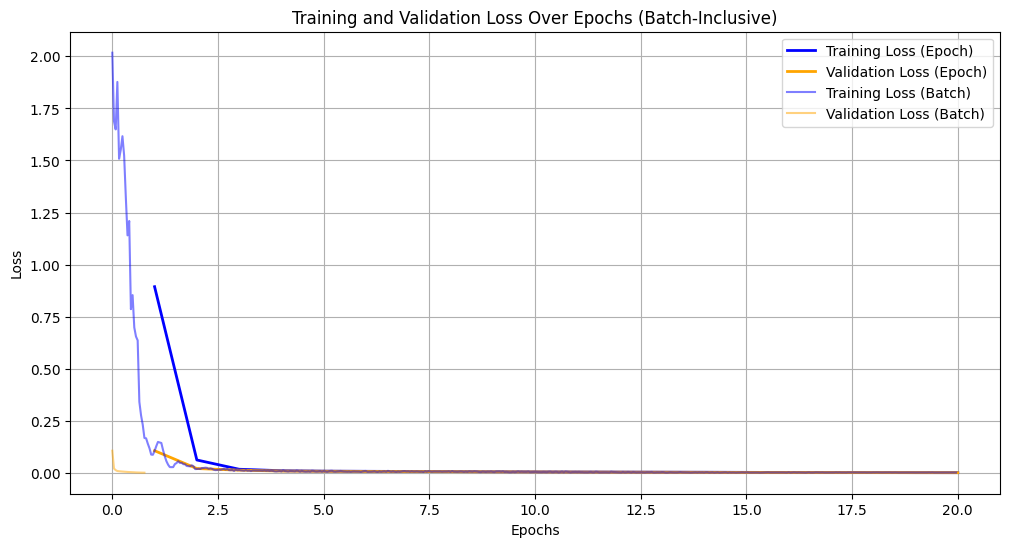

In [ ]:
#Plot training loss

train_dataset_size = len(train_dataset)
batches_per_epoch = train_dataset_size // batch_size

#Rescale batch x-axis values to align with epochs
train_batch_x = [i / batches_per_epoch for i in range(len(train_batch_losses))]
valid_batch_x = [i / batches_per_epoch for i in range(len(valid_batch_losses))]

#Plot epoch-level losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss (Epoch)', color='blue', linewidth=2)
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss (Epoch)', color='orange', linewidth=2)

#Plot batch-level losses with rescaled x-axis
plt.plot(train_batch_x, train_batch_losses, label='Training Loss (Batch)', color='blue', alpha=0.5, )
plt.plot(valid_batch_x, valid_batch_losses, label='Validation Loss (Batch)', color='orange', alpha=0.5, )

#Add labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Batch-Inclusive)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from torchsummary import summary
import torchsummary

torchsummary.summary(model, (1, sequence_length))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1000]             192
              ReLU-2             [-1, 32, 1000]               0
         MaxPool1d-3              [-1, 32, 500]               0
            Conv1d-4              [-1, 16, 500]           1,552
              ReLU-5              [-1, 16, 500]               0
         MaxPool1d-6              [-1, 16, 250]               0
            Conv1d-7              [-1, 16, 250]             784
              ReLU-8              [-1, 16, 250]               0
          Upsample-9              [-1, 16, 500]               0
           Conv1d-10              [-1, 32, 500]           2,592
             ReLU-11              [-1, 32, 500]               0
         Upsample-12             [-1, 32, 1000]               0
           Conv1d-13              [-1, 1, 1000]              97
         Identity-14              [-1, 

In [ ]:
#Save the model
torch.save(model.state_dict(), 'autoencoder_time_series_model.pth')

In [ ]:
#Load model
model = CNNAutoencoder()
model.load_state_dict(torch.load('autoencoder_time_series_model.pth'))
model.eval()

<ipython-input-54-06c6ccfc61a6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder_time_series_model.pth'))


CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): Identity()
  )
)

Threshold for anomaly detection: 0.0073
True anomalies count: 1000
False anomalies count: 10
False normal count: 0
True normal count: 990


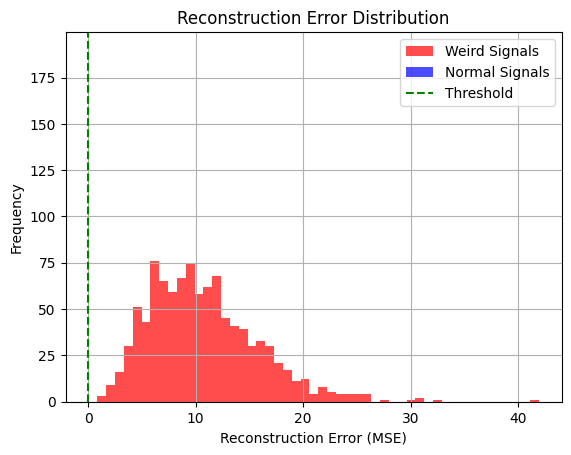

In [ ]:
#Prepare normal and weird signals for testing

#normal_frequencies = np.linspace(-3.5, 3.5, 1000)
#weird_frequencies = np.linspace(-4, 4, 1000)

#normal_amplitudes = np.linspace(-1.2, 1.2, 1000)
#weird_amplitudes = np.linspace(-1.4, 1.4, 1000)


normal_signals_test = build_signals(normal_frequencies, normal_amplitudes, num=1000, num_components=5)
weird_signals_test = build_signals(weird_frequencies, weird_amplitudes, num=1000, num_components=5)

#Reshape signals for the model
sequence_length = len(normal_signals_test[0])
normal_signals_test = normal_signals_test.reshape(len(normal_signals_test), 1, sequence_length)  # (batch_size, 1, sequence_length)
weird_signals_test = weird_signals_test.reshape(len(weird_signals_test), 1, sequence_length)    # (batch_size, 1, sequence_length)

#Convert to PyTorch tensors
normal_signals_test = torch.tensor(normal_signals_test, dtype=torch.float32).to(device)
weird_signals_test = torch.tensor(weird_signals_test, dtype=torch.float32).to(device)

#Evaluate reconstruction error (MSE) for both normal and weird signals
model.eval()
with torch.no_grad():
    #Reconstruct normal signals
    reconstructed_normal = model(normal_signals_test)
    mse_normal = torch.mean((normal_signals_test - reconstructed_normal) ** 2, dim=(1, 2)).cpu().numpy()  # MSE per signal

    #Reconstruct weird signals
    reconstructed_weird = model(weird_signals_test)
    mse_weird = torch.mean((weird_signals_test - reconstructed_weird) ** 2, dim=(1, 2)).cpu().numpy()  # MSE per signal

#Define the anomaly detection threshold
threshold = np.percentile(mse_normal, 99)  # Set threshold as the 99th percentile of normal signals' MSE

#Classify anomalies
true_anomalies = mse_weird > threshold  #Weird signals correctly identified as anomalies
false_anomalies = mse_normal > threshold  #Normal signals incorrectly flagged as anomalies
false_normal = mse_weird <= threshold  #Weird signals misclassified as normal
true_normal = mse_normal <= threshold  #Normal signals correctly classified as normal

#Count occurrences for evaluation
true_anomalies_count = np.sum(true_anomalies)
false_anomalies_count = np.sum(false_anomalies)
false_normal_count = np.sum(false_normal)
true_normal_count = np.sum(true_normal)

#Print results
print(f"Threshold for anomaly detection: {threshold:.4f}")
print(f"True anomalies count: {true_anomalies_count}")
print(f"False anomalies count: {false_anomalies_count}")
print(f"False normal count: {false_normal_count}")
print(f"True normal count: {true_normal_count}")

#Plot MSE distributions
#plt.figure(figsize=(10, 5))
plt.hist(mse_weird, bins=50, alpha=0.7, label='Weird Signals', color='red')
plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Signals', color='blue')
plt.axvline(x=threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid()
plt.show()

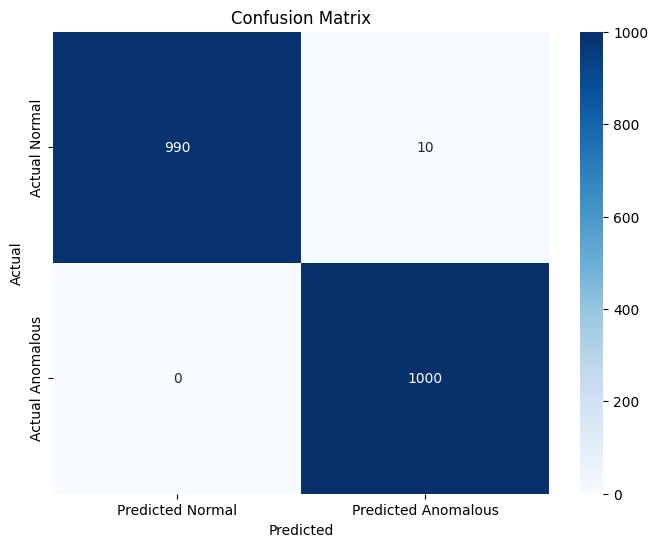

In [ ]:
import seaborn as sns
#Confusion matrix
conf_matrix = np.array([[true_normal_count, false_anomalies_count],
                        [false_normal_count, true_anomalies_count]])
#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Normal', 'Predicted Anomalous'],
            yticklabels=['Actual Normal', 'Actual Anomalous'])
xticklabels=['Predicted Normal', 'Predicted Anomalous']
yticklabels=['Actual Normal', 'Actual Anomalous']
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()